In [1]:
import torch                                  
import torch.nn as nn                          
import torch.nn.functional as F  

import numpy as np      

import time
import flappy_bird_gym

import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32                                 
LR = 0.001                                       
EPSILON = 0.999                 
GAMMA = 0.9                                     
TARGET_REPLACE_ITER = 100                       
MEMORY_CAPACITY = 1000

env = flappy_bird_gym.make("FlappyBird-v0")         
N_ACTIONS = env.action_space.n                 
N_STATES = env.observation_space.shape[0] 

In [3]:
class Net(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden):                                                        
       
        super(Net, self).__init__()                                             
        self.fc1 = nn.Linear(n_states, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        #self.fc4 = nn.Linear(n_hidden, n_hidden)
        #self.fc5 = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, n_actions)                                     
        
    def forward(self, x):                                                       
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        #x = F.relu(self.fc5(x))
        actions_value = self.out(x)                                           
        return actions_value       
    

In [4]:
class DQN(object):
    def __init__(self, n_states, n_actions, n_hidden, 
                 batch_size, lr, epsilon, gamma, target_replace_iter, memory_capacity): 
                                                             
        self.eval_net = Net(n_states, n_actions, n_hidden)
        self.target_net = Net(n_states, n_actions, n_hidden)
        
        self.learn_step_counter = 0                                             
        self.memory_counter = 0
        #multi step
        self.memory = np.zeros((MEMORY_CAPACITY, (N_STATES * 2 + 2)*5))
        self.a=np.zeros( N_STATES * 2 + 2)
        self.b=np.zeros( N_STATES * 2 + 2)
        self.c=np.zeros( N_STATES * 2 + 2)
        self.d=np.zeros( N_STATES * 2 + 2)
        
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)    
        self.loss_func = nn.MSELoss()
        
        self.loss_record=[]

    def choose_action(self, x):                                                 
        x = torch.unsqueeze(torch.FloatTensor(x), 0)                            
        if np.random.uniform() < EPSILON:                                       
            actions_value = self.eval_net.forward(x)                            
            action = torch.max(actions_value, 1)[1].data.numpy()                
            action = action[0]                                                  
        else:                                                                  
            action = np.random.randint(0, N_ACTIONS)                        
        return action                                                           

    def store_transition(self, state, action, reward, next_state):   
        
        if self.memory_counter==0:
            transition = np.hstack((self.a,self.b,self.c,self.d,state, [action, reward], next_state))
            self.d=np.hstack((state, [action, reward], next_state))
            
        elif self.memory_counter==1:
            transition = np.hstack((self.a,self.b,self.c,self.d,state, [action, reward], next_state))
            self.c=self.d
            self.d=np.hstack((state, [action, reward], next_state))
            
        elif self.memory_counter==2:
            transition = np.hstack((self.a,self.b,self.c,self.d,state, [action, reward], next_state))
            self.b=self.c
            self.c=self.d
            self.d=np.hstack((state, [action, reward], next_state))
            
        elif self.memory_counter==3:
            transition = np.hstack((self.a,self.b,self.c,self.d,state, [action, reward], next_state))
            self.a=self.b
            self.b=self.c
            self.c=self.d
            self.d=np.hstack((state, [action, reward], next_state))
        
        else:

            transition = np.hstack((self.a,self.b,self.c,self.d,state, [action, reward], next_state))
            self.a=self.b
            self.b=self.c
            self.c=self.d
            self.d=np.hstack((state, [action, reward], next_state))
        
        #transition = np.hstack((state, [action, reward], next_state))                                

        index = self.memory_counter % MEMORY_CAPACITY                           
        self.memory[index, :] = transition                                      
        self.memory_counter =self.memory_counter + 1                                                

    def learn(self):                                                            
        
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:                  
            self.target_net.load_state_dict(self.eval_net.state_dict())         
        self.learn_step_counter = self.learn_step_counter + 1                                            

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)            #選要sample的index
        b_memory = self.memory[sample_index, :]                                 
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
       
        b_r1 = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_r2 = torch.FloatTensor(b_memory[:, N_STATES+1+10:N_STATES+2+10])
        b_r3 = torch.FloatTensor(b_memory[:, N_STATES+1+20:N_STATES+2+20])
        b_r = b_r1+b_r2*GAMMA+b_r3*GAMMA*GAMMA#reward sum
       
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        q_eval = self.eval_net(b_s).gather(1, b_a)
  
        q_next = self.target_net(b_s_).detach()#不反向傳播
  
        q_target = b_r + (GAMMA**3) * q_next.max(1)[0].view(BATCH_SIZE, 1)
    
        loss = self.loss_func(q_eval, q_target)
        
        self.loss_record.append(loss)
        
        self.optimizer.zero_grad()                                      
        loss.backward()                                                 
        self.optimizer.step()
        

    def plot_loss(self):
        
        plt.plot(np.arange(len(self.loss_record)),self.loss_record,'r')
        plt.title("Loss Record") # title
        plt.ylabel("Loss") # y label
        plt.xlabel("Step") # x label
        plt.show()
        
    def save_params(self):
        #print(self.eval_net.state_dict())
        torch.save(self.eval_net.state_dict(),'params.pkl')
    
    def load_params(self):
        self.eval_net.load_state_dict(torch.load('params.pkl'))

In [5]:
dqn = DQN(N_STATES,N_ACTIONS,128,BATCH_SIZE,LR,EPSILON,GAMMA,TARGET_REPLACE_ITER,MEMORY_CAPACITY) 

In [6]:
#new reward
score_record=[]
reward_record=[]


new_reward=0
in_area=0
is_pass=0
is_crash=0

score=0

episode=500

for i in range(episode):

    print('<<<<<<<<<Episode: %s' % (i+1))
    state = env.reset()  

    episode_reward_sum = 0                                              

    new_reward=0
    while True:
      
        action = dqn.choose_action(state)                                        
        next_state, reward, done, info = env.step(action)
         
        #env.render()
        #time.sleep(1 / 300) 
        
        #k=(abs(next_state[1])+abs(next_state[2]))/2
        
        if next_state[0]<0.2:
           
            if (next_state[1]>0 and next_state[2]<0):
                if abs(next_state[1])>abs(next_state[2]):
                    in_area=0.3*abs(next_state[2])
                else:
                    in_area=0.3*abs(next_state[1])
            else:
                if (next_state[1]<0 and next_state[2]<0):
                    in_area=(-0.3)*abs(next_state[1])
                else:
                    in_area=(-0.3)*abs(next_state[2])

                         
        else:
            in_area=0
        
        
        
        if done==True:
            is_crash=-1
        else:
            is_crash=0
        
        if info['score']>score:
            score=score+1
            is_pass=1
        else:
            is_pass=0      
      
        new_reward=in_area+reward*0.0001+is_pass+is_crash
                
        dqn.store_transition(state, action, new_reward, next_state) 
        
        episode_reward_sum = episode_reward_sum + new_reward                           

        state = next_state                                               

        if dqn.memory_counter > MEMORY_CAPACITY:              
            
            dqn.learn()

        if done:

            print(next_state, episode_reward_sum,info)
            score_record.append(info['score'])
            reward_record.append(episode_reward_sum)
            
            break
            
    #env.close()         
            
env.close() 

dqn.save_params()

<<<<<<<<<Episode: 1
[ 0.02430556 -0.50117188 -0.65117187  0.1       ] -2.9878796875 {'score': 0}
<<<<<<<<<Episode: 2
[ 0.02430556 -0.34882812 -0.49882813  0.1       ] -2.3480359374999997 {'score': 0}
<<<<<<<<<Episode: 3
[ 0.02430556 -0.58125    -0.73125     0.1       ] -3.3242078125 {'score': 0}
<<<<<<<<<Episode: 4
[ 0.02430556 -0.43867187 -0.58867187  0.1       ] -2.7253796875 {'score': 0}
<<<<<<<<<Episode: 5
[ 0.02430556 -0.37226562 -0.52226562  0.1       ] -2.4464734375 {'score': 0}
<<<<<<<<<Episode: 6
[ 0.02430556 -0.43671875 -0.58671875  0.1       ] -2.7171765625 {'score': 0}
<<<<<<<<<Episode: 7
[ 0.02430556 -0.42109375 -0.57109375  0.1       ] -2.6515515625 {'score': 0}
<<<<<<<<<Episode: 8
[ 0.02430556 -0.41132812 -0.56132812  0.1       ] -2.6105359375 {'score': 0}
<<<<<<<<<Episode: 9
[ 0.02430556 -0.40546875 -0.55546875  0.1       ] -2.5859265625 {'score': 0}
<<<<<<<<<Episode: 10
[ 0.02430556 -0.41132812 -0.56132812  0.1       ] -2.6105359375 {'score': 0}
<<<<<<<<<Episode: 11
[ 

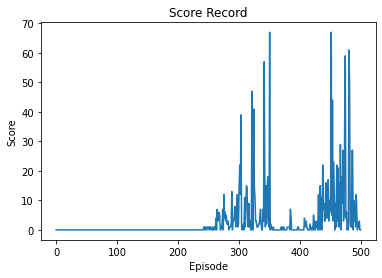

In [7]:
plt.plot(np.arange(len(score_record)),score_record)
plt.title("Score Record")
plt.ylabel("Score") 
plt.xlabel("Episode") 
plt.show()

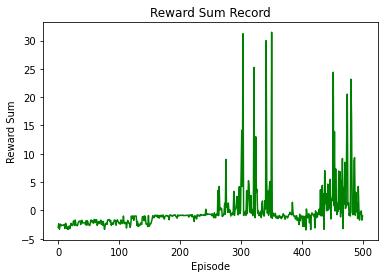

In [8]:
plt.plot(np.arange(len(reward_record)),reward_record,'g')
plt.title("Reward Sum Record") 
plt.ylabel("Reward Sum") 
plt.xlabel("Episode") 
plt.show()

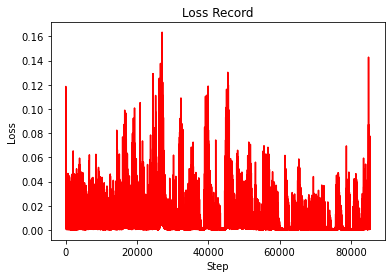

In [9]:
dqn.plot_loss()

In [10]:
max_score=0
score_sum=0
reward_sum=0

for i in range(episode):
    if max_score<score_record[i]:
        max_score=score_record[i]
    reward_sum=reward_sum+reward_record[i]
    score_sum=score_sum+score_record[i]

print(max_score)
print(score_sum)
print(reward_sum)

67
1522
-99.22517187500193
